In [ ]:
!{sys.executable} -m pip install pandas 

In [1]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths, subFrame, preprocesing_data, combinePictures, combineModels, classesInLabels, combineLabelClasses, lessBands
import sys 
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.semi_supervised import SelfTrainingClassifier
import pandas as pd
from sklearn import datasets
import copy
import spectral


In [2]:
#Finding path names 
Mjosa_data = split_dataset_paths("../Datasets/2022_07_11_Mjosa/2022_07_11_Mjosa/", ["he5", "csv", "jpg"])
Andebu_data = split_dataset_paths("../Datasets/2021_07_21_Andebu/2021_07_21_Andebu/", ["he5", "csv", "jpg"])
Telemark_data = split_dataset_paths("../Datasets/2020_06_23_Telemarkskanalen/2020_06_23_Telemarkskanalen/", ["he5", "csv", "jpg"])


In [3]:
#Indian pines dataset laod 
indian_pines_gt = scipy.io.loadmat("../HyperSpectralData/Hyperspectral Remote Sensing Scenes/Indian_pines_gt.mat")
indian_pines = scipy.io.loadmat("../HyperSpectralData/Hyperspectral Remote Sensing Scenes/Indian_pines.mat")

indian_pines = indian_pines["indian_pines"]
indian_pines_gt = indian_pines_gt["indian_pines_gt"]



NameError: name 'indian_pines' is not defined

In [235]:
#Amount of dataset should be handled
N_datasets = 4

#Open files 
open_files_array = []
for i in range(N_datasets):
    file = tab.open_file(Mjosa_data["he5"][i])
    open_files_array.append(file.get_node("/HDFEOS/SWATHS/PRS_L1_HCO/")['Data Fields']['VNIR_Cube'][:,5:,:])

#Load the labels 
load_labels_array = []
for i in range(N_datasets):
    file = Mjosa_data["csv"][i]
    load_labels_array.append(np.loadtxt(file, dtype=np.ubyte))

In [291]:
#Pick data and labels also subframes. 

data = open_files_array[3]
labels = load_labels_array[3]

sub_data, sub_labels = subFrame(data, labels, 0, 300, 0, 300)
new_labels = combineLabelClasses(sub_labels, [0,1,2,3])
n_labels = combineLabelClasses(sub_labels, [4,5])
#sub_data = lessBands(data = sub_data, n_band_dim = 3)

ind_labels = combineLabelClasses(indian_pines_gt, [7,8,9,10,11,12,13,14,15])



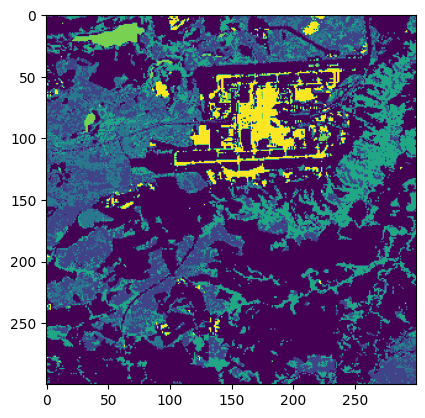

In [292]:
plt.imshow(sub_labels)

[7, 3, 6, 5, 4, 1, 8, 2, 0]


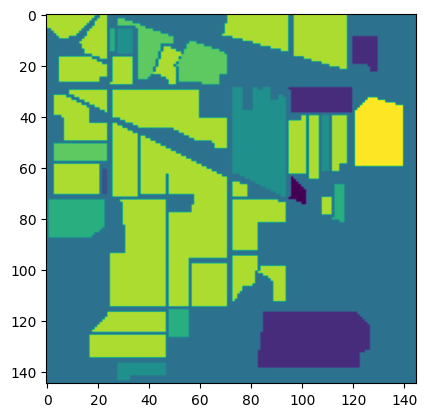

In [293]:
plt.imshow(ind_labels)
print(classesInLabels(ind_labels))

In [303]:
def preprocesing_data(data,labels): 
    # prepare data
    X = data.transpose(0,2,1).reshape((-1,61))
    y = labels.flatten()

    X = preprocessing.scale(X, axis=0)                    # Normalization
    #X = preprocessing.normalize(X, axis=0) 
    return X,y 
    
def preprocesing_data2(data,labels): 
    # prepare data
    X = data.reshape((-1,3))
    y = labels.flatten()

    scaler = preprocessing.MinMaxScaler()
    #scaler = preprocessing.StandardScaler()

    scaler.fit(X)
    X = scaler.transform(X)

    #X = preprocessing.scale(X, axis=0)                    # Normalization
    #X = preprocessing.normalize(X, axis=0) 
    return X,y 


X, y =  preprocesing_data(data, labels)
X_sub, y_sub = preprocesing_data(sub_data, sub_labels)
#X, y = preprocesing_data2(ind_data, ind_labels)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.999, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


(1000, 61) (999000, 61) (1000,) (999000,)


In [302]:
"""
svma = SVC(
    C = 1,
    kernel = "rbf", 
    degree = 3,
    gamma = "scale", 
    coef0 = 0.0, 
    probability = True, 
    tol = 1e-3, 
    cache_size = 400,
    class_weight = None, 
    verbose = True, 
    max_iter = 1e5, 
    decision_function_shape = "ovr",
    break_ties = True, 
    random_state = 1
)
"""
svma = SVC(C = 10, kernel = "linear", max_iter=1e5, tol=1e-5)

svma.fit(X_train, y_train)
print("support vectors:", len(svma.support_))
print(svma.classes_)

support vectors: 430
[0 1 2 3 4 5]


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [305]:
svma.score(X_sub, y_sub)

0.16934444444444444

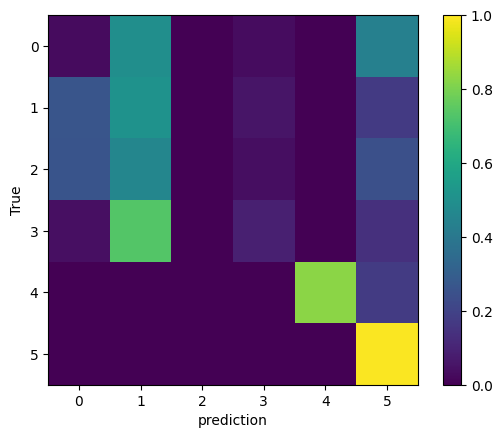

In [304]:
Xout = svma.predict(X_sub)

plt.imshow(Xout.reshape((300,300)))

cm = confusion_matrix(y_true = y_sub, y_pred = Xout, normalize='true')

plt.imshow(cm, vmax=1, vmin=0) 
plt.ylabel('True')
plt.xlabel('prediction')
plt.colorbar()

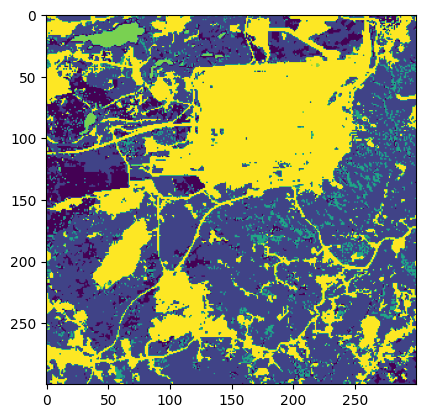

In [306]:
plt.imshow(Xout.reshape((300,300)))